In [1]:
#CNN-LSTM predict closing stock price of a corporation (Apple).

In [2]:
#import libraries
import math
import pandas_datareader as web
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D, TimeDistributed
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
#get the stock quote
df = web.DataReader('AAPL', data_source='yahoo', start='2010-10-10', end='2020-10-10')
#show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-10-11,10.615714,10.521428,10.526428,10.548572,427753200.0,9.025835
2010-10-12,10.696428,10.446072,10.550357,10.662143,558544000.0,9.123012
2010-10-13,10.784286,10.707143,10.721429,10.719286,630092400.0,9.171908
2010-10-14,10.802500,10.728572,10.774643,10.796785,435296400.0,9.238219
2010-10-15,11.250000,10.889643,10.980000,11.240714,922194000.0,9.618066
...,...,...,...,...,...,...
2020-10-05,116.650002,113.550003,113.910004,116.500000,106243800.0,116.299355
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,112.965111
2020-10-07,115.550003,114.129997,114.620003,115.080002,96849000.0,114.881805


In [4]:
#get the number of rows and columns in the data set
df.shape

(2518, 6)

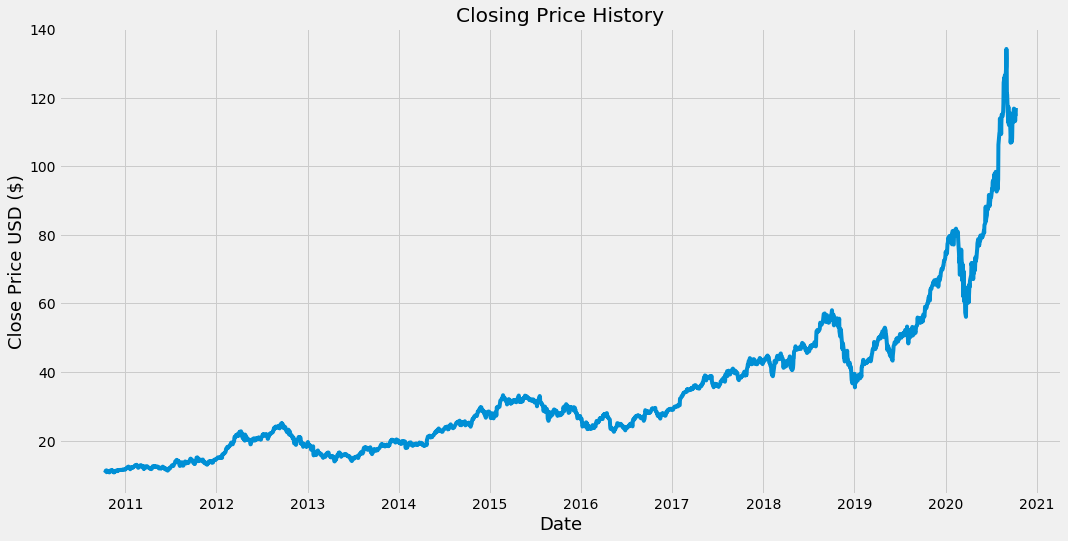

In [5]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
#create a new dataframe with only the "Close column"
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on (80%)
training_data_len = math.ceil(len(dataset)*.8)

training_data_len 

2015

In [7]:
#Scale the data (normalization - better performance)
scaler =  MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00091863],
       [0.00138083],
       ...,
       [0.8455086 ],
       [0.84461886],
       [0.86079597]])

In [8]:
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.00091863, 0.00138083, 0.00200769, 0.00559844,
       0.00654017, 0.00408183, 0.00438226, 0.0040905 , 0.0034983 ,
       0.00389406, 0.00366585, 0.0036023 , 0.0028541 , 0.00162349,
       0.00254789, 0.00404428, 0.00503802, 0.00661818, 0.00628886,
       0.00671928, 0.00598553, 0.00654884, 0.00615019, 0.00366007,
       0.00337408, 0.0017997 , 0.00148482, 0.00377562, 0.00328453,
       0.00519978, 0.00386229, 0.00561577, 0.00567354, 0.00621375,
       0.00456137, 0.00607797, 0.00658351, 0.00637841, 0.00716126,
       0.00660084, 0.00740969, 0.0070486 , 0.0072797 , 0.00760036,
       0.0072017 , 0.00722192, 0.00747903, 0.00729415, 0.00775635,
       0.00833121, 0.00860853, 0.00815789, 0.00846988, 0.00869809,
       0.00864609, 0.00817522, 0.00785746, 0.00988248, 0.01037936])]
[0.011162211857498244]

[array([0.        , 0.00091863, 0.00138083, 0.00200769, 0.00559844,
       0.00654017, 0.00408183, 0.00438226, 0.0040905 , 0.0034983 ,
       0.00389406, 0.00366585, 0.0

In [9]:
#convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape the data (CNN-LSTM expects 4 dimentionals - 2 months of 30 days, total 60 days)
x_train = np.reshape(x_train, (x_train.shape[0], 2, 30, 1))
x_train.shape

(1955, 2, 30, 1)

In [10]:
#build CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(None, 1, 1))))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))


In [11]:
#compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=20)
model.summary()

Epoch 1/20
1955/1955 [==============================] - 5s 3ms/step - loss: 4.7342e-04
Epoch 2/20
1955/1955 [==============================] - 5s 3ms/step - loss: 2.3126e-04
Epoch 3/20
1955/1955 [==============================] - 5s 3ms/step - loss: 1.6002e-04
Epoch 4/20
1955/1955 [==============================] - 5s 3ms/step - loss: 1.4442e-04
Epoch 5/20
1955/1955 [==============================] - 5s 3ms/step - loss: 1.2314e-04
Epoch 6/20
1955/1955 [==============================] - 5s 3ms/step - loss: 1.0589e-04
Epoch 7/20
1955/1955 [==============================] - 5s 3ms/step - loss: 1.1906e-04
Epoch 8/20
1955/1955 [==============================] - 5s 3ms/step - loss: 9.1031e-05
Epoch 9/20
1955/1955 [==============================] - 5s 3ms/step - loss: 9.0596e-05
Epoch 10/20
1955/1955 [==============================] - 5s 3ms/step - loss: 7.0579e-05
Epoch 11/20
1955/1955 [==============================] - 5s 3ms/step - loss: 7.7508e-05
Epoch 12/20
1955/1955 [==================

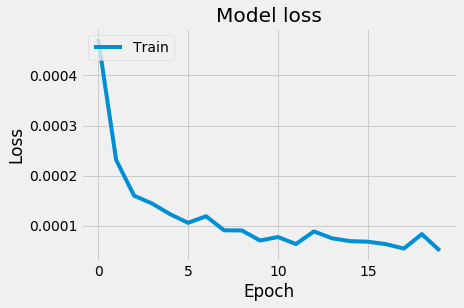

In [13]:
#show model loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
#create the testing data set
#create a new array containing scaled values from index 
test_data = scaled_data[training_data_len - 60: , : ]
#create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], 2, 30, 1))
x_test.shape

(503, 2, 30, 1)

In [17]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
#get the root mean squared error (RMSE) (lower values better fit)
rmse = np.sqrt( np.mean( predictions - y_test)**2)
print(rmse)

1.8241232763938828


In [19]:
#get the mean absolute error (average of the forecast error values - all of em forced to be positive)
mae = mean_absolute_error(y_test, predictions)
print(mae)

3.567602859102708


In [20]:
#define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#get MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(mape)

4.5218863742519675


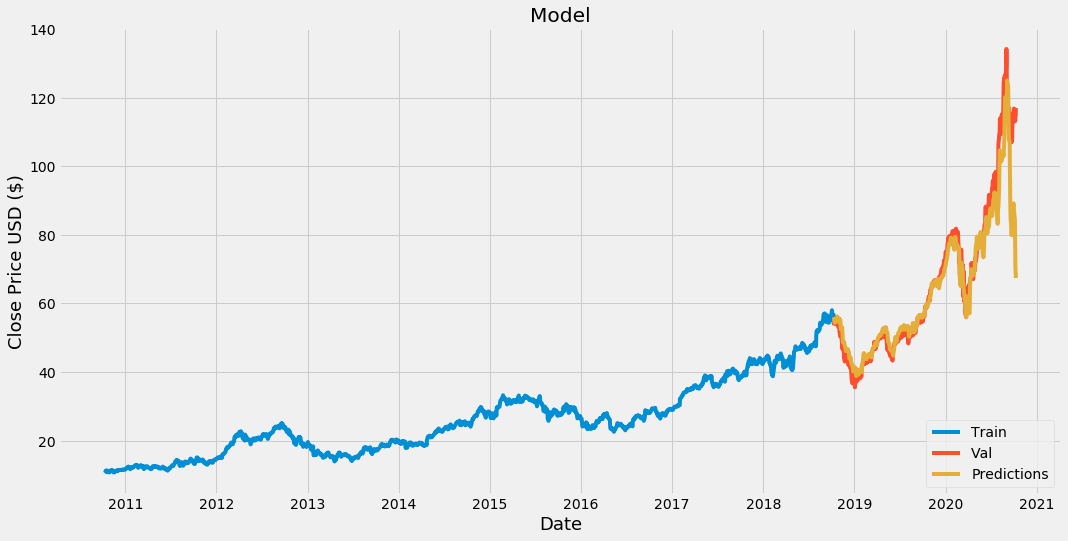

In [21]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

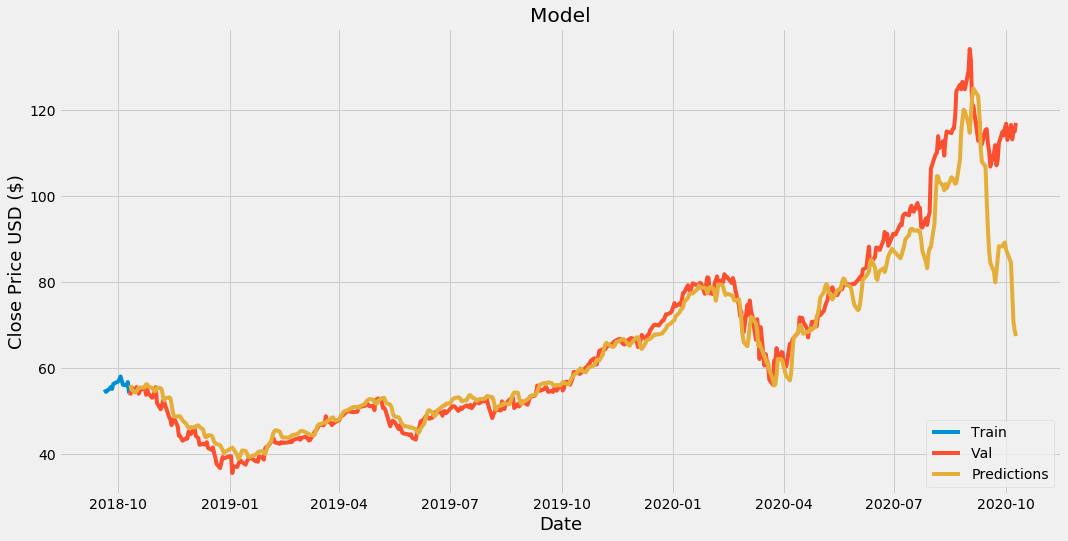

In [22]:
#plot zoomed in
train = data[2000:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-10-11,53.612499,56.003777
2018-10-12,55.527500,55.041153
2018-10-15,54.340000,54.352108
2018-10-16,55.537498,54.488213
2018-10-17,55.297501,54.945984
...,...,...
2020-10-05,116.500000,84.458900
2020-10-06,113.160004,77.243011
2020-10-07,115.080002,70.691063


In [24]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2010-01-01', end='2020-08-19')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], 2, 30, 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[102.82678]]


In [25]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-08-20', end='2020-08-20')
print(apple_quote2['Close'])

Date
2020-08-20    118.275002
Name: Close, dtype: float64
